# Yolov7 Pytorch

This notebook shows how to compile Yolov7/Pytorch to AWS Inferentia (inf1 instances) using NeuronSDK.

Reference: https://github.com/WongKinYiu/yolov7

## 1) Install Dependencies

Verify that this Jupyter notebook is running the Python kernel environment that was set up according to the [Inf1 PyTorch Installation Guide](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/general/setup/torch-neuron.html#setup-torch-neuron). You can select the kernel from the 'Kernel -> Change Kernel' option on the top of this Jupyter notebook page.

In [ ]:
#Install pytorch 1.10
!python -m pip install torch-neuron==1.10.2.* neuron-cc[tensorflow] "protobuf" torchvision

### 1.1) Create a patch to fix an issue related to inline ops

We need to apply a patch to avoid inline ops and optimize the way constants are used.

In [ ]:
%%writefile yolov7.inplace.patch
diff --git a/models/yolo.py b/models/yolo.py
index 95a019c..bfa83f0 100644
--- a/models/yolo.py
+++ b/models/yolo.py
@@ -257,50 +257,62 @@ class IKeypoint(nn.Module):

             bs, _, ny, nx = x[i].shape  # x(bs,255,20,20) to x(bs,3,20,20,85)
             x[i] = x[i].view(bs, self.na, self.no, ny, nx).permute(0, 1, 3, 4, 2).contiguous()
-            x_det = x[i][..., :6]
-            x_kpt = x[i][..., 6:]
-
+            x_shape=list(x[i].shape)
+
             if not self.training:  # inference
                 if self.grid[i].shape[2:4] != x[i].shape[2:4]:
                     self.grid[i] = self._make_grid(nx, ny).to(x[i].device)
-                kpt_grid_x = self.grid[i][..., 0:1]
-                kpt_grid_y = self.grid[i][..., 1:2]
+
+                # split into (x1,y1,x2,y2,conf,clsid) ([x,y,conf]*17)
+                if self.inplace:
+                    kpt_grid_x = self.grid[i][..., 0:1]
+                    kpt_grid_y = self.grid[i][..., 1:2]
+                    x_det = x[i][..., :6]
+                    x_kpt = x[i][..., 6:]
+                else:
+                    x_det,x_kpt = x[i].split((6,x_shape[-1]-6),4)

                 if self.nkpt == 0:
                     y = x[i].sigmoid()
                 else:
                     y = x_det.sigmoid()
-
+
                 if self.inplace:
                     xy = (y[..., 0:2] * 2. - 0.5 + self.grid[i]) * self.stride[i]  # xy
                     wh = (y[..., 2:4] * 2) ** 2 * self.anchor_grid[i].view(1, self.na, 1, 1, 2) # wh
                     if self.nkpt != 0:
+                        kpt_grid_x,kpt_grid_y = self.grid[i].split((1,1),4)
+
                         x_kpt[..., 0::3] = (x_kpt[..., ::3] * 2. - 0.5 + kpt_grid_x.repeat(1,1,1,1,17)) * self.stride[i]  # xy
                         x_kpt[..., 1::3] = (x_kpt[..., 1::3] * 2. - 0.5 + kpt_grid_y.repeat(1,1,1,1,17)) * self.stride[i]  # xy
-                        #x_kpt[..., 0::3] = (x_kpt[..., ::3] + kpt_grid_x.repeat(1,1,1,1,17)) * self.stride[i]  # xy
-                        #x_kpt[..., 1::3] = (x_kpt[..., 1::3] + kpt_grid_y.repeat(1,1,1,1,17)) * self.stride[i]  # xy
-                        #print('=============')
-                        #print(self.anchor_grid[i].shape)
-                        #print(self.anchor_grid[i][...,0].unsqueeze(4).shape)
-                        #print(x_kpt[..., 0::3].shape)
-                        #x_kpt[..., 0::3] = ((x_kpt[..., 0::3].tanh() * 2.) ** 3 * self.anchor_grid[i][...,0].unsqueeze(4).repeat(1,1,1,1,self.nkpt)) + kpt_grid_x.repeat(1,1,1,1,17) * self.stride[i]  # xy
-                        #x_kpt[..., 1::3] = ((x_kpt[..., 1::3].tanh() * 2.) ** 3 * self.anchor_grid[i][...,1].unsqueeze(4).repeat(1,1,1,1,self.nkpt)) + kpt_grid_y.repeat(1,1,1,1,17) * self.stride[i]  # xy
-                        #x_kpt[..., 0::3] = (((x_kpt[..., 0::3].sigmoid() * 4.) ** 2 - 8.) * self.anchor_grid[i][...,0].unsqueeze(4).repeat(1,1,1,1,self.nkpt)) + kpt_grid_x.repeat(1,1,1,1,17) * self.stride[i]  # xy
-                        #x_kpt[..., 1::3] = (((x_kpt[..., 1::3].sigmoid() * 4.) ** 2 - 8.) * self.anchor_grid[i][...,1].unsqueeze(4).repeat(1,1,1,1,self.nkpt)) + kpt_grid_y.repeat(1,1,1,1,17) * self.stride[i]  # xy
                         x_kpt[..., 2::3] = x_kpt[..., 2::3].sigmoid()

                     y = torch.cat((xy, wh, y[..., 4:], x_kpt), dim = -1)

                 else:  # for YOLOv5 on AWS Inferentia https://github.com/ultralytics/yolov5/pull/2953
-                    xy = (y[..., 0:2] * 2. - 0.5 + self.grid[i]) * self.stride[i]  # xy
-                    wh = (y[..., 2:4] * 2) ** 2 * self.anchor_grid[i]  # wh
+
+                    xy, wh, conf = y.split((2, 2, self.nc + 1), 4)  # y.tensor_split((2, 4, 5), 4)  # torch 1.8.0
+                    xy = xy * (2. * self.stride[i]) + (self.stride[i] * (self.grid[i] - 0.5))  # new xy
+                    wh = wh ** 2 * (4 * self.anchor_grid[i].data)  # new wh
+
                     if self.nkpt != 0:
-                        y[..., 6:] = (y[..., 6:] * 2. - 0.5 + self.grid[i].repeat((1,1,1,1,self.nkpt))) * self.stride[i]  # xy
-                    y = torch.cat((xy, wh, y[..., 4:]), -1)
+                        # avoid using reshape and contiguous, not to get OOM while compiling with torch.neuron
+                        # these ops create copies of the tensors they are operating.
+
+                        # split xy from confidence. we need to add a new axis before slicing
+                        kxy,kc = x_kpt.view(list(x_kpt.shape)[:-1] + [self.nkpt,3]).split((2,1),5)
+                        kxy_shape=list(kxy.shape)
+
+                        # make grid with a shape compatible with the new kxy
+                        grid = self.grid[i].view(list(self.grid[i].shape)[:-1] + [1,2])
+                        kxy = (kxy * 2.0 - 0.5 + grid) * self.stride[i]
+                        # finally concatenate xy + conf.sigmoid back to the final tensor
+                        x_kpt = torch.cat((kxy, kc.sigmoid()), 5).view(kxy_shape[:-2] + [-1])
+                    y = torch.cat((xy, wh, conf, x_kpt), 4)

                 z.append(y.view(bs, -1, self.no))
-
-        return x if self.training else (torch.cat(z, 1), x)
+        return torch.cat(z, 1)
+        #return x if self.training else (torch.cat(z, 1), x)

     @staticmethod
     def _make_grid(nx=20, ny=20):


### 1.2) Clone the official YoloV7 repo

We'll use commit 8c0bf3f

In [ ]:
import os

if not os.path.isdir('yolov7'):
    !git clone https://github.com/WongKinYiu/yolov7 && \
        cd yolov7 && \
        git checkout 8c0bf3f && \
        git apply ../yolov7.inplace.patch

## 2) Initialize libraries and prepare input samples

In [ ]:
import io
import os
import sys
import torch
import urllib
import tarfile
import torch.neuron
if 'yolov7' not in sys.path: sys.path.insert(0, 'yolov7')

In [ ]:
if not os.path.isfile('yolov7-w6-pose.pt'):
    urllib.request.urlretrieve(
        'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt',
        'yolov7-w6-pose.pt'
    )
x = torch.rand(1,3,960,960).float()

In [ ]:
#Install other packages
%pip install pandas requests opencv-python tqdm matplotlib seaborn PyAML "numpy<=1.21.6"

## 3) Load a pre-trained model and check if it is .jit traceable

In [ ]:
model = torch.load('yolov7-w6-pose.pt', map_location='cpu')['model'].eval().float()
model.model[-1].inplace = False
y = model(x) # warmup
try:
    traced = torch.jit.trace(model, x)    
    print("Cool! Model is jit traceable")
except Exception as e:
    print("Ops. Something went wrong. Model is not traceable")

## ok the model is .jit traceable. now let's compile it with NeuronSDK

## 4) Analyze & compile the model for Inferentia with NeuronSDK

Neuron Check Model tool provides user with basic information about the compiled and uncompiled model’s operations without the use of TensorBoard-Neuron.
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-tools/tutorial-neuron-check-model.html

The PyTorch-Neuron trace Python API provides a method to generate PyTorch models for execution on Inferentia, which can be serialized as TorchScript. It is analogous to torch.jit.trace() function in PyTorch.
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-frameworks/pytorch-neuron/api-compilation-python-api.html?highlight=trace


In [ ]:
import torch
import torch.neuron
torch.neuron.analyze_model(model, example_inputs=x)

In [ ]:
# Requires ~10GB free RAM to compile the model
# It takes ~10mins on a c5.2xlarge

import torch
import torch.neuron
model_neuron = torch.neuron.trace(
    model, example_inputs=x,
    #dynamic_batch_size=True,
    #compiler_args['--neuron-core-pipeline', '4']
)

## Export to saved model
model_neuron.save("yolov7_neuron.pt")

### 4.1) Verify the optimized model

In [ ]:
y = model_neuron(x)
%timeit model_neuron(x)

## 5) A simple test to check the predictions

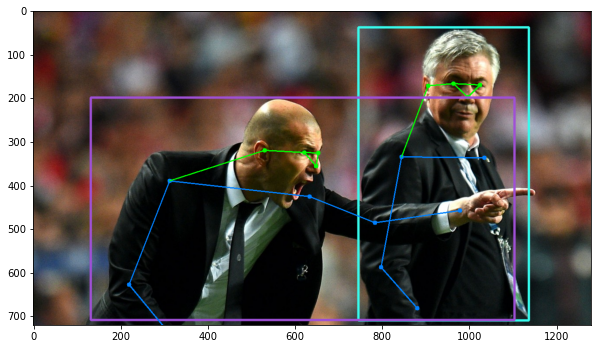

In [12]:
%matplotlib inline
import os
import cv2
import sys
import torch
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
if 'yolov7' not in sys.path: sys.path.append('yolov7')
from torchvision import transforms
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts, plot_one_box, color_list

if not os.path.exists("zidane.jpg"):
    urllib.request.urlretrieve(
        "https://ultralytics.com/images/zidane.jpg", "zidane.jpg")
        
nkpt=17
img_size=960
# load an image
img = cv2.imread('zidane.jpg')
h,w,c = img.shape
factor = img_size/w
new_h = int(h*factor)
# build a squared tensor
x = np.zeros((w,w,c), dtype=np.uint8)
x[:h, :w] = img[:]
x = cv2.cvtColor(cv2.resize(x, (960,960)), cv2.COLOR_BGR2RGB)
x = x.transpose(2,0,1).astype(np.float32) / 255.0
x = torch.from_numpy(np.expand_dims(x, axis=0))

# invoke the model and post-process the predictions
y = model_neuron(x)
detections = non_max_suppression_kpt(y, 0.25, 0.65, nc=1, nkpt=nkpt, kpt_label=True)

tensor_shape,img_shape = (img_size,new_h),(h,w)
for det in detections:
    det = det.detach().numpy()
    bboxes,scores,classes,keypoints = det[:, :4],det[:, 4], det[:, 5],det[:,6:]
    bboxes = bboxes.clip(0,tensor_shape[0])
    
    tw,th,ih,iw = *tensor_shape, *img_shape    
    bboxes = (bboxes / [tw,th,tw,th] * [iw,ih,iw,ih])
    keypoints = keypoints / ([tw,th,1]*nkpt) * ([iw,ih,1]*nkpt)
    
    for bbox,kpts in zip(bboxes,keypoints):
        plot_one_box(bbox,img)
        plot_skeleton_kpts(img, kpts.T, 3)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))